Initially we import all the packages we need.

In [71]:
import pandas as pd
import pickle
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random as rd

Firstly we read the data file and then we divide the given data into name of the sequence list and DNA sequence list.

When we observe dna_string_list, we can find only four possible classes with 'a','c','g','t'. And also all the columns are categorical. In order to calculate distance between each character we have to assign a numerical value to each of them.

For example, here we have to use Hamming distance which calculates the number of positions at which the sequences are different.

Reference : https://en.wikipedia.org/wiki/Hamming_distance 

So we represent 'a' as 1, 'c' as 2,'g' as 3 and 't' as 4. Instead of assigning 1,2,3,4 if we assign  random values like 5,10,400,2000,etc., we end with wrong calculation.

In [72]:
# Reading the file and creating two lists 1.sequence list 2.dna list
def read_file(file_name):
    sequence_list = []
    dna_list = []
    dna_string_list  = []
    with open(file_name, 'r') as f:
        count = 0
        for i in f:
            if count % 2 == 0:
                sequence_list.append(i[1:-1])
            if count % 2 == 1:
                dna_list.append(list(i[:-1]))
                dna_string_list.append(i[:-1])
            count += 1             

    return sequence_list, dna_list, dna_string_list

# creating data frame and convert the strings to numbers 
def create_df(dna_list):
    dna_df = pd.DataFrame(dna_list)   
    dna_df.to_csv('HW2_string.csv')
    DNA = {'A': 1, 'C': 2, 'G' : 3, 'T':4 }
    dna_df.replace(to_replace=DNA, inplace=True)
    return dna_df


#caluclating hamming distance
def hamming_df(dna_string_list):
    
    n = len(dna_string_list)
    
    main_dist_list = []
    for i in range(n):
        main_dist_list.append([0]*n)
    
    for i in range(n):
        for j in range(i+1,n):
           ham_dist = hamdist(dna_string_list[i],dna_string_list[j])
           main_dist_list[i][j] = ham_dist
           main_dist_list[j][i] = ham_dist
    hamming_df = pd.DataFrame(main_dist_list)
    return hamming_df
    

def hamdist(str1, str2):
    diffs = 0
    for ch1, ch2 in zip(str1, str2):
        if ch1 != ch2:
            diffs += 1
    return diffs

# saving the data frame and the sequence_list using pickle
def save_df(df, ham_df, sequence_list):
    df.to_csv('HW2.csv')
    ham_df.to_csv('HW2_ham.csv')
    with open('seq_list.pkl','wb') as f:
        pickle.dump(sequence_list, f)
        
def main():
    file_name = "HW2.fas"
    seq_list, dna_list, dna_string_list = read_file(file_name)
    df = create_df(dna_list)
    ham_df = hamming_df(dna_string_list)
    save_df(df, ham_df, seq_list)

if __name__ == "__main__":
    main()

Projecting 2D sequence with MultiDimensional Scaling using hamming distance file. Here HW2_ham.csv has hamming distance calculations which we calculated in the above function.

We use hamming distance file and perform MDS. 

Reference for MDS : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html 

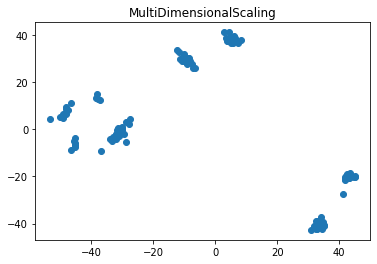

In [73]:
#MDS plot

def main(): 
    ham_df = pd.read_csv("HW2_ham.csv", index_col = 0)
    model = MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=1,dissimilarity='precomputed')
    mds_output = model.fit_transform(ham_df)
    principalDf = pd.DataFrame(data = mds_output, columns = ['X', 'Y'])
    principalDf.to_csv("HW2_mds.csv")
    plt.scatter(mds_output[:, 0], mds_output[:, 1],label='MDS')
    plt.title('MultiDimensionalScaling')
if __name__ == "__main__":
    main()

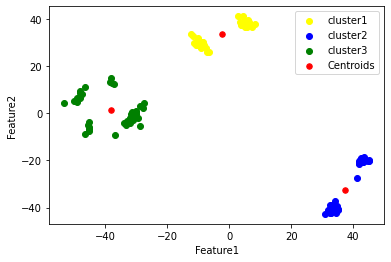

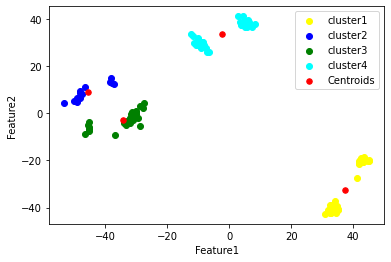

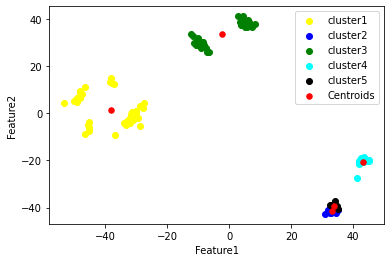

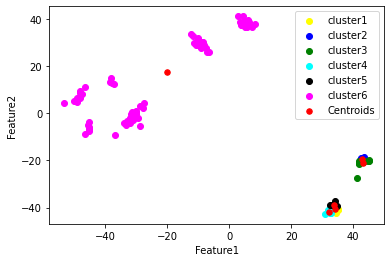

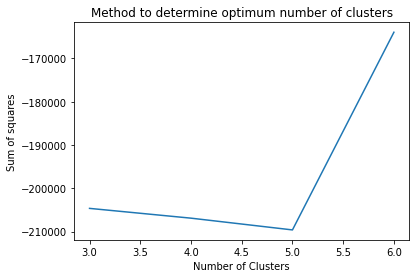

In [76]:
#Visualizing plots for MDS with different clusters highlighted in different colors.
def kmeans(file_name, num_clusters, mode):
    
    X = pd.read_csv(file_name,index_col=0)
    m = X.shape[0]
    n = X.shape[1]
    
    n_iter=100
    K = num_clusters # number of clusters
    
    Centroids=np.array([]).reshape(n,0)
    for i in range(K):
        rand=rd.randint(0,m-1)
        Centroids=np.c_[Centroids,X.iloc[rand]]

    Output={}
    EuclidianDistance=np.array([]).reshape(m,0)
    for k in range(K):
        tempDist=np.sum((X-Centroids[:,k])**2,axis=1)
        EuclidianDistance=np.c_[EuclidianDistance,tempDist]
    C = np.argmin(EuclidianDistance,axis=1) + 1

    Y={}
    for k in range(K):
        Y[k+1]=np.array([]).reshape(2,0)
    for i in range(m):
        Y[C[i]]=np.c_[Y[C[i]],X.iloc[i]]        
    for k in range(K):
        Y[k+1]=Y[k+1].T        
    for k in range(K):
        Centroids[:,k]=np.mean(Y[k+1],axis=0)
    
    for j in range(n_iter):
        #step 2.a
        EuclideanDistance=np.array([]).reshape(m,0)
        for k in range(K):
            tempDist=np.sum((X-Centroids[:,k])**2,axis=1)
            EuclideanDistance=np.c_[EuclideanDistance,tempDist]
        C=np.argmin(EuclideanDistance,axis=1)+1
        #step 2.b
        Y={}
        for k in range(K):
            Y[k+1]=np.array([]).reshape(2,0)
        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],X.iloc[i]]
        
        for k in range(K):
            Y[k+1]=Y[k+1].T
        
        for k in range(K):
            Centroids[:,k]=np.mean(Y[k+1],axis=0)
        if j > 0 and all(np.array_equal(Y[key], Output[key]) for key in Y):
            break
        Output = Y

    color=['yellow','blue','green','cyan','black','magenta','brown']
    labels=['cluster1','cluster2','cluster3','cluster4', 'cluster5', 'cluster6']

    for k in range(K):
        plt.scatter(Output[k+1][:,0],Output[k+1][:,1],c=color[k],label=labels[k])
    
    plt.scatter(Centroids[0,:],Centroids[1,:],s=30,c='red',label='Centroids')
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    plt.legend()
    plt.show('clustered_{}_{}.png'.format(K, mode))
    plt.clf()

    return Output, Centroids

def sum_of_squares(Output,Centroids,num_clusters):
    sum_of_squares = 0
    Centroids = Centroids.T
    for k in range(num_clusters):
        sum_of_squares += np.sum((Output[k+1] - Centroids[k,:]**2))
    return sum_of_squares

def plot_elbow(sum_of_squares,mode):
    k_array = np.arange(3,7)
    plt.plot(k_array, sum_of_squares)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of squares')
    plt.title('Method to determine optimum number of clusters')
    plt.show("elbow_{}.png".format(mode))

def main():
    sum_of_square_mds = np.array([])
    sum_of_square_pca = np.array([])
    for i in range(3,7):
        Output, Centroids = kmeans("HW2_MDS.csv",i, "mds")
        sum_of_square_mds = np.append(sum_of_square_mds,sum_of_squares(Output, Centroids, i))

    plot_elbow(sum_of_square_mds,"mds")

if __name__ == "__main__":
    main()


In this problem we started with 3 number of clusters and calculated till 6 number of clusters. To find out the best value for the k in K-means clustering, I used elbow method to determine optimum number of clusters. From the visualization grapgh of elbow methos using k = 5 number of clusters is optimum.